# Audio classification for clap sounds

- Built using reinforcement learning based on YAMNet model
- Then we trained it on ~20 samples of single and double claps sounds each

# Install TensorFlow and audio libraries for audio conversion

In [136]:
!sudo apt-get update -y
!sudo apt-get install ffmpeg -y
!pip install pydub
!pip install "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install "tensorflow_io==0.28.*"
!pip install tensorflow-hub

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://ppa.launchpadcontent.net/criu/ppa/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease




ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 106 not upgraded.


# Convert raw .m4a audio files into .wav files

In [137]:
from pydub import AudioSegment
import os


def convert_audio_to_wav(input_file, output_file):
    audio = AudioSegment.from_file(input_file)
    audio.export(output_file, format='wav')


def convert_directory_to_wav(input_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for file_name in os.listdir(input_directory):
        input_file = os.path.join(input_directory, file_name)
        if os.path.isfile(input_file):
            base_name, extension = os.path.splitext(file_name)
            output_file = os.path.join(output_directory, base_name + '.wav')
            convert_audio_to_wav(input_file, output_file)


# Example usage:
single_claps_input_directory = 'clap_sounds/raw/single_claps'
single_claps_output_directory = 'clap_sounds/converted/single_claps'
convert_directory_to_wav(single_claps_input_directory, single_claps_output_directory)

double_claps_input_directory = 'clap_sounds/raw/double_claps'
double_claps_output_directory = 'clap_sounds/converted/double_claps'
convert_directory_to_wav(double_claps_input_directory, double_claps_output_directory)

# Transfer learning with YAMNet for environmental sound classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network that can predict audio events from [521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), such as laughter, barking, or a siren.

In [138]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [139]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [140]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

<source src="data:audio/wav;base64,UklGRnjVAABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YVTVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAQD//wEAAAABAAAA/f8EAPj/QQBoAFIAYgBiAGgAawB3AGkAZgBzAHQAdgBvAHgAdwB0AHYAfgCDAHkAhQCRAIgAjwCVAJMAmQCbAKcAsgCdAJ0AtACkAKgAvQCrAKoAuQC0ALMAsAC1ALkArwC7AK4AswC6AKkAwQC+AK4AsAC0ALsAwACyAKgAzQC6AK8AxQC9AMcAuQC8ALoAuADIAK4AsgC+ALEApgCsALYArQCcAKEAvQChAJQAswCoAJoApACpAJgAnAChAJYAkwCWAJIAhwCMAIoAewB3AHoAbwBqAGkAbgBpAGIAXgBgAFsATQBYAEoAUwBJADMAOAA4ADwAMAAnACUAJwATAAoAGwAOAAgAAwAAAAEA/v8GAPL/5P/g/+v/5f/Q/9r/1f/T/8P/uP+0/67/nf+X/53/h/9//27/ef+F/2z/Yf9m/2P/Xf9b/0b/Rf9T/0v/Nf87/0f/O/80/zL/Mv8v/yn/JP8l/yv/Hf8q/zD/Af8V/y3/Ef8L/xX/Gf8Q/wj/E/8Q/wr/Ff8M/wv/Df8F/wr/EP8H//7+//4K/wP/7/7+/hf/BP/3/h3/Mv8a/xf/Lf84/0D/Nf9O/2X/Rv9L/1v/av9a/1X/ev9x/3D/cP99/4//ff+b/6H/jP+w/7j/pv+p/8H/xv/G/7T/1P8EAMX/1P///wIA9//p/xIADQAMAPj/BgA0ADQAOQAzAEsAMgBDAEYAMgBSAFcAcwBKAFYAkwBaAEYAdgCSAI0AZwBwAHkAjQCGAHAAeQCAAKMAlACUAIoAfgCNAJsAlgCbALMAmACSALMAxgCyAL0AtACMAJ8AvwDCAKMAqQDVANcAoQCVALgAywC7AIQAuQDoAK8ArADKAMsAtQClAM8ADAELAdYAuQC5AMkAwACtAJkAkQCqAKgAtADKAPIA5wC9ANgA6ADPALcAxgC7AKYArQC/AM4ArQCwAM8AwQCtALUAuQC+ALwAogCxALwAlgCVAMcArACOAJEAmACfAJQAnAB5AG4AhACDAGsAaABrAGwAWQBZAH4ASwBLAFwAPABBAD8AQAAzADgAOAAhADkALgAZAC8AJgAPAP7/CwATAOz/7f8AAPn/+f/Z/8n/1P/F/8P/v/+7/6z/nP+V/5f/nv+d/5X/i/98/2j/cf92/2n/aP9Y/2X/cf9b/1P/VP9W/z3/QP9Z/1b/Pv84/0j/Qf87/0D/PP8w/zf/Pv8s/xv/MP8q/wv/G/8s/yj/Lf8q/x//Lf8k/xP/Lv8r/xz/Hv8X/xn/If8m/yD/Kf8x/zH/O/86/0b/X/9R/1T/c/9p/3H/ff+D/4P/jv+X/4T/oP+f/5D/r//A/7P/uP/R/8z/yf/B/8n/5P/i/+X/6f/3//n/+v8FAAkAFwAYABoAJQAhACQAQABFADQASABMAEMAYABnAFgAVgBjAGkAYQB0AHkAeQCLAIUAeACDAJEAggB7AJgAjABuAIMAjwCDAIQAlgCUAI0AnACWAIoAowCsAJsAoACnALsAvACnAKgAvQC/AK8AvgDGAMUAvgDAALkAxADWAMQAvQDFANgAzADNAMYAzgDJALUAygDBAMYAwgDEAM0A1wDTALgA1gDWAM0A3QDNAMUAxwDTANEAzADKANIA3ADQANYAyADMAMoAvwDAAMIA1wDGALUAwADHAMMAqwC2AM4AtgCwALgAvQCsAKMAsACgAJ0AogCgAJ4AiACMAJ0AhwB+AH8AeQB6AHUAZABpAGgAXABnAFYAUwBXAEgAQABGAEAAMwBBADgAMwAxACAAGgAdABQA/f/2////AwDo/+D/6//S/8X/wv/R/77/ov+m/6n/pP+J/4b/ev9//33/bP9s/2b/X/9R/03/Qf9G/0X/M/86/zL/I/8y/zP/Iv8h/yr/JP8Q/w3/Gv8i/xP/Ef8H/

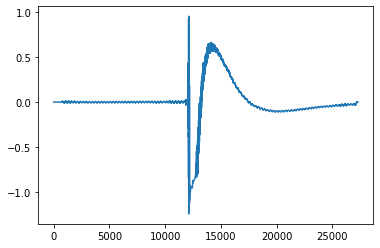

In [141]:
# load test audio file
clap_wav_data = load_wav_16k_mono("clap_sounds/test_sounds/clap.wav")

_ = plt.plot(clap_wav_data)

# Play the audio file.
display.Audio(clap_wav_data, rate=16000)

# Load the class mapping from YAMNet

In [142]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])

# for name in class_names[:20]:
#   print(name)
# print('...')

# Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.

In [143]:
# run inference on clap.wav

scores, embeddings, spectrogram = yamnet_model(clap_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Slap, smack
The embeddings shape: (3, 1024)


## Create claps_metadata.csv based on file names of training data

In [144]:
import csv
import os

# Specify the directory where your WAV files are located
directory = 'clap_sounds/converted'

# Initialize an empty list to store the file details
file_list = []


# Walk through the subdirectories
for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith(".wav"):
            # Extract the necessary information from the filename
            category = os.path.basename(root)  # Get the name of the subdirectory

            # Append the file details to the list
            file_list.append([os.path.join(root, filename), category])


# Print the file details as CSV
print('filename, category')
for file_details in file_list:
    print(','.join(str(detail) for detail in file_details))


# Specify the output CSV file path
output_file = 'clap_sounds/claps_metadata.csv'

# Write the file details to the CSV file
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'category'])  # Write header
    writer.writerows(file_list)

print("CSV file created successfully.")

filename, category
clap_sounds/converted/double_claps/double_clap_1.wav,double_claps
clap_sounds/converted/double_claps/double_clap_6.wav,double_claps
clap_sounds/converted/double_claps/double_clap_11.wav,double_claps
clap_sounds/converted/double_claps/double_clap_3.wav,double_claps
clap_sounds/converted/double_claps/double_clap_21.wav,double_claps
clap_sounds/converted/double_claps/double_clap_4.wav,double_claps
clap_sounds/converted/double_claps/double_clap_8.wav,double_claps
clap_sounds/converted/double_claps/double_clap_13.wav,double_claps
clap_sounds/converted/double_claps/double_clap_19.wav,double_claps
clap_sounds/converted/double_claps/double_clap_15.wav,double_claps
clap_sounds/converted/double_claps/double_clap_17.wav,double_claps
clap_sounds/converted/double_claps/double_clap_7.wav,double_claps
clap_sounds/converted/double_claps/double_clap_12.wav,double_claps
clap_sounds/converted/double_claps/double_clap_0.wav,double_claps
clap_sounds/converted/double_claps/double_clap_10.

# Read in csv and convert to Pandas dataframe

In [145]:
# read in our .csv

claps_metadata_csv = './clap_sounds/claps_metadata.csv'
base_data_path = './clap_sounds/output/'

pd_data = pd.read_csv(claps_metadata_csv)
pd_data.head()

,filename,category
0,clap_sounds/converted/double_claps/double_clap...,double_claps
1,clap_sounds/converted/double_claps/double_clap...,double_claps
2,clap_sounds/converted/double_claps/double_clap...,double_claps
3,clap_sounds/converted/double_claps/double_clap...,double_claps
4,clap_sounds/converted/double_claps/double_clap...,double_claps


# Specify class names of sounds that we're trying to identify

In [146]:
my_classes = ['double_claps', 'single_claps']

# Add fold column which'll be used later onto to split into train, test, validation

fold value is randomly generated between 1-5, inclusive

In [147]:
import random
random.seed(42) # Setting seed for reproducibility

folds_pd = pd_data.copy()

# Assign fold value to each row
for index, row in pd_data.iterrows():
    folds_pd.at[index, 'fold'] = random.randint(1, 5)

folds_pd['fold'] = folds_pd['fold'].astype(int)  # Convert 'fold' column to integers

folds_pd.head(10)

,filename,category,fold
0,clap_sounds/converted/double_claps/double_clap...,double_claps,1
1,clap_sounds/converted/double_claps/double_clap...,double_claps,1
2,clap_sounds/converted/double_claps/double_clap...,double_claps,3
3,clap_sounds/converted/double_claps/double_clap...,double_claps,2
4,clap_sounds/converted/double_claps/double_clap...,double_claps,2
5,clap_sounds/converted/double_claps/double_clap...,double_claps,2
6,clap_sounds/converted/double_claps/double_clap...,double_claps,1
7,clap_sounds/converted/double_claps/double_clap...,double_claps,5
8,clap_sounds/converted/double_claps/double_clap...,double_claps,1
9,clap_sounds/converted/double_claps/double_clap...,double_claps,5


# Add target column which just converts category column into an integer

In [148]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a deep copy of the folds_pd DataFrame
category_id_pd = folds_pd.copy()

# Encode the "category" column in target
label_encoder = LabelEncoder()
category_id_pd["target"] = label_encoder.fit_transform(category_id_pd["category"])

# Create a category mapping dictionary if needed
# category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

category_id_pd.head(100)

,filename,category,fold,target
0,clap_sounds/converted/double_claps/double_clap...,double_claps,1,0
1,clap_sounds/converted/double_claps/double_clap...,double_claps,1,0
2,clap_sounds/converted/double_claps/double_clap...,double_claps,3,0
3,clap_sounds/converted/double_claps/double_clap...,double_claps,2,0
4,clap_sounds/converted/double_claps/double_clap...,double_claps,2,0
5,clap_sounds/converted/double_claps/double_clap...,double_claps,2,0
6,clap_sounds/converted/double_claps/double_clap...,double_claps,1,0
7,clap_sounds/converted/double_claps/double_clap...,double_claps,5,0
8,clap_sounds/converted/double_claps/double_clap...,double_claps,1,0
9,clap_sounds/converted/double_claps/double_clap...,double_claps,5,0


# Load the audio files

Here we use the `load_wav_16k_mono` function and prepare the WAV data for the model.

In [149]:
filenames = category_id_pd['filename']
targets = category_id_pd['target']
folds = category_id_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [150]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [151]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' Run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

# Split the data

We use the `fold` column to split the dataset into train, validation and test sets.
Then, we remove the `fold` column from the dataset since we're not going to use it during training.

- `fold` values b/t 1-3 are for train
- `fold` values that are 4 are for validation
- `fold` values that are 5 are for test

In [152]:
cached_ds = main_ds.cache()

# Split data based on 'fold' value
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Create model

Next, we define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to distinguish single and double claps.

In [153]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [154]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [155]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
4/4 [==============================] - 2s 124ms/step - loss: 1.0162 - accuracy: 0.4845 - val_loss: 1.1080 - val_accuracy: 0.2000
Epoch 2/20
4/4 [==============================] - 0s 9ms/step - loss: 0.6908 - accuracy: 0.7423 - val_loss: 1.0075 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 0s 10ms/step - loss: 0.4828 - accuracy: 0.7835 - val_loss: 1.1331 - val_accuracy: 0.2000
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 0.5158 - accuracy: 0.7732 - val_loss: 0.9693 - val_accuracy: 0.3333
Epoch 5/20
4/4 [==============================] - 0s 8ms/step - loss: 0.5684 - accuracy: 0.7320 - val_loss: 0.7939 - val_accuracy: 0.5333
Epoch 6/20
4/4 [==============================] - 0s 9ms/step - loss: 0.6241 - accuracy: 0.7423 - val_loss: 0.8735 - val_accuracy: 0.4667


Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [156]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1/1 [==============================] - 0s 181ms/step - loss: 0.6893 - accuracy: 0.7600
Loss:  0.6892582178115845
Accuracy:  0.7599999904632568


# Test model

<source src="data:audio/wav;base64,UklGRiTAAABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YQDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//wAA/P8AAP3/AQD8////8//6//n/+P8AAOj/8gCJAVYBdgFoAV4BWQGGAXsBVwFxAYEBbAF2AY8BhwF/AYEBgwF/AW4BfgGaAYgBfgF+AYkBiAF/AXQBXgFZAW8BdgFnAXMBeQFxAXMBbgFnAXcBfwFwAWsBcgFXAUYBWgFIAUcBUwFBATUBMwE+AToBIAEUAQ8BCAEDAQcBEgEGAfoAAgECAfcA6ADlAOEA0QC/AMsAyQCvALYArACYAIkAggB3AFkARwBJAEAAKAAcAA8AAQDr/9z/xv+u/53/lP+R/3//fP9t/1b/Q/82/zP/Jf8X/xP/Ef8M/wv/+v7u/u3+5f7Y/s/+1P7Q/sX+tv64/sT+vv62/rX+q/6f/qz+p/6c/pv+kP6O/on+jP5+/nf+hf5y/nL+gP51/m3+cf5s/lj+Xf5l/lP+Wv5m/lj+XP5l/mn+c/5+/pH+pv6m/qT+w/7H/sn+1f7h/vL+8/4B/wf/Ef8l/y3/Of9J/1L/Wf9n/3L/hf+H/5L/t/+y/7P/x//h/+j/6v8HAA0AGAAiACsARABOAGUAaQBhAHwAiwCMAJgAqQCyAK4AtgC9AM0A1gDcAPIA8QD+AAUBAwENARMBEwEUARQBDwERARMBGgEfARkBIgEvATABNgE1AToBSQFKAUQBVgFlAVsBcAF5AWoBdwGJAY4BiQGSAZ0BoAGpAaYBpgGzAa4BqwG9AbgBtAG+AcUBxwHFAcsBwAHDAdMB0QHXAdgB1QHSAdEB2AHhAfAB8AHvAfEB5QHhAegB7QHgAd4B6QHsAe0B5gHqAeoB5QHsAe0B5wHhAeAB6wHwAewB8AH1AewB8QH4AeMB4AHkAdoB1wHYAdsBygHFAdUBzQG4AbkBsAGdAaYBmwGFAYQBhAFyAWcBaAFSAUoBSwE/ATMBKwEkARkBEwETAf8A/wD8AOYA8ADyANkAxQDMALMAmgCbAHgAbgB2AFsAOQAuACEADQD6/+f/7f/T/7z/uP+i/4r/hv+B/2f/aP9m/0r/RP9I/zD/Hv8e/wz/CP8B//n+8v7r/ub+3f7R/sj+1P7F/r7+rv6w/rf+rf6j/pf+nP6T/ov+if6V/o3+gP53/oT+fv5r/nv+cP5l/mz+Y/5a/lz+Xf5d/lX+XP5f/l7+Vv5g/mv+df6S/oj+kv6g/rH+sP6x/sn+xv7W/vH+9P70/gf/EP8X/xn/K/88/0L/Uv9h/3H/eP9//4b/lP+i/67/tP/H/9v/2P/p//X/8/8BAAgAGwAnADUAUQBdAGgAawBzAHIAiwCbAJQApQCwAMMAzADRANUA0wDgAOEA3wDlAO0A6gDxAPMA6gD1APUA/AD5AAIBDwELAQ8BFAEVARgBHQEqATMBMwFDAUgBVQFZAWEBaQFmAX0BfQF/AX4BfwGTAZYBnAGfAaYBrQGoAZ4BoAGrAa0BqgGvAbsBvgHBAbkBuwG8AcABxAHFAc4BywHDAb4BzwHJAb0BvwG/AcUBxwHKAcsBzAHOAdIBxgHQAdYBzwHTAcoByAHLAdMB1wHQAdIBzAHcAdUBxwHXAdQB5gHXAc8B1gHOAcMBtwG/AboBvQG0Aa0BqwGiAZkBkgGHAX8BegFwAWYBVgFgAUoBPwFAASgBMQEpASIBGwEWARIBBQH+APIA6gDYAMsAwwC6ALIApACGAG4AZQBTAEEAOAAiAA8ABwDx/93/y/+5/6j/oP+O/3j/cv9q/1X/RP9B/zH/JP8j/xb/A/8E//3+8v7w/t7+1f7N/sT+w/66/rT+uf62/qj+o/6g/pX+mv6c/o3+hf6N/o/+d/57/nv+a/5q/l/+YP5n/mX+Vv5R/lf+V/5P/lH+VP5Q/lP+RP5M/k/+RP5V/mn+c/58/of+jf6X/qL+s/69/sL+z/7e/ub+9P7//gb/Df8V/yb/N/89/0D/U/9k/

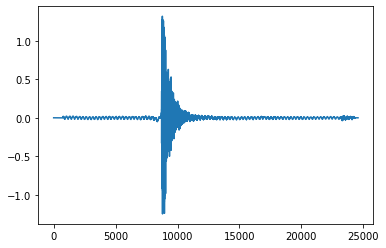

In [157]:
# load my test audio file clap_sounds/clap.wav
# clap_wav_data = load_wav_16k_mono("clap_sounds/clap.wav")
# clap_wav_data = load_wav_16k_mono("clap_sounds/converted/double_claps/double_clap_1.wav")
clap_wav_data = load_wav_16k_mono("clap_sounds/converted/single_claps/single_clap_3.wav")

_ = plt.plot(clap_wav_data)

# Play the audio file.
display.Audio(clap_wav_data, rate=16000)

In [158]:
scores, embeddings, spectrogram = yamnet_model(clap_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: single_claps


# Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.

In [159]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [160]:
saved_model_path = './clap_sounds/clap_sounds_model'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./clap_sounds/clap_sounds_model/assets


INFO:tensorflow:Assets written to: ./clap_sounds/clap_sounds_model/assets


# Load saved model to verify that it works as expected.

In [161]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [162]:
reloaded_results = reloaded_model(clap_wav_data)
result_class = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {result_class}')

# serving_results = reloaded_model.signatures['serving_default'](clap_wav_data)
# result_class = my_classes[tf.math.argmax(serving_results['classifier'])]
# print(f'The main sound is: {result_class}')

The main sound is: single_claps


# Some more testing using the test split dataset only

A random audio .wav file is chosen each time

clap_sounds/converted/double_claps/double_clap_13.wav
Waveform values: [0. 0. 0. ... 0. 0. 0.]


<source src="data:audio/wav;base64,UklGRs7aAABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YaraAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAP//AAD//wAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP//AAD+/wEAAAACAP//AQD7/wAAAAD3/w0Aff85/1v/R/9X/0//Yf9i/2T/af91/3//fP+C/4r/kf+P/5n/mf+b/6f/rv+4/77/wv/I/8r/z//R/9P/2P/c/+b/7v/v//X/+P/9/wgAEQAZAB8AIQAlACcAJQAtADYAOgA8AD4APQBDAEwATABLAFEAVQBVAFgAXABgAGQAYQBhAGcAawBmAGIAagBwAG8AcgB3AHcAewCBAIIAgwCEAIYAjwCVAJsAoQCkAKUApQCnAKkAqgCsAKsAqQCsAKkAowCjAKUAogCeAKMApAChAKAApQCqAKkArwCwAKsArACuALEAswCyALIAsQCyALYAtACxALcAuAC0ALEAsgC0ALIAswCtALAAtwCxALAAswCzALAAsACxALIArgCuALIArwCwALAArQCtAK0ArQCqAKMApgCnAKYAnwCXAJQAjgCNAIgAiACFAH0AfwCCAH0AcgBsAGsAaABjAGIAXQBcAFgAUABRAE0ARQA7ADUANAAqACUAHAAQAAcABwAEAPb/8f/t/+X/3f/W/87/x//G/8D/t/+z/6r/pP+k/5f/kf+S/4z/hv+C/37/c/9v/3X/b/9p/2T/Xv9e/1j/Uv9R/1D/TP9H/0n/R/9G/0H/PP86/zr/Of8v/zD/Mv8u/yn/Kv8t/yf/KP8n/yD/Hv8d/xv/Gf8Y/xX/FP8W/xH/D/8P/xH/E/8Y/xn/Iv8u/yz/Nf87/zz/P/9C/0j/UP9Y/1b/WP9g/2r/b/9x/3r/gP+I/5H/k/+Z/57/pf+v/7X/u//C/8f/z//T/9P/3f/l/+b/7f/u//H/+/8AAAMABwAOABMAFQAWAB8AKAArADMANwA6AEAAQgA+AEIARgBFAEkATQBRAE4ATwBPAFAAVABXAFgAWQBYAFgAXQBdAFwAXgBlAGkAbQBwAHMAdwB6AIEAfgCCAI0AjACMAJEAlgCYAJ0AoACiAKEAnQCjAKkApwCiAKUApgCjAKgArACpAKsAsQCuAK0AsQCyALIAsQC3ALQAsAC0ALAAtAC5ALMAtQC3ALgAvgC7ALoAuAC1ALcAtwC2AK4AtAC3ALAAswC4ALYAsgC1ALcAvAC9ALgAtwC1ALcAvQC+ALcAtQC2ALAArgCvAK0ApgCjAKEAnQCfAJgAlwCWAI8AkACIAH4AfwB+AHwAegByAGwAawBoAGQAYABdAFoAVQBRAE0ASQBDADkAMQAqACYAGwASAA8ABgACAPz/8v/t/+T/2f/W/87/wf+8/7n/tf+r/6n/o/+V/5D/jv+H/33/fP97/3P/b/9y/23/aP9m/2D/Xf9W/1b/VP9T/1P/T/9Q/03/Sf9G/0P/PP88/z3/OP84/zX/Nv8z/zL/MP8p/yz/Mv8s/yb/Kf8l/yP/Iv8d/yH/I/8h/yD/Iv8g/yH/Kf8s/zL/Nv87/z//Rv9J/07/XP9a/1n/aP9u/23/dP95/3r/gf+H/4j/kv+Y/53/pP+n/67/rv+z/77/w//F/9D/1v/X/+D/6v/o/+//+//5////BgAIAAoAEAAVABgAIQAmACgALwAzADcAPwBAAD4AQQBDAEMARQBFAEgASQBHAE4AUABKAE0ATgBSAFQAVgBZAFQAWABXAF0AYwBkAGcAaQBuAG0AcwB4AHUAdgB6AHsAfAB/AIMAggCGAIgAhgCOAJMAjwCNAJMAlwCVAJIAkQCYAJ8AmQCYAJoAkwCTAJwAnwCbAJ0AoQCeAJ0ApACiAJ4ApACmAKYApwCoAKgAqgCpAKgAqACjAKgAqwChAKAAowCqAKkAqQCvAKkApwCqAK4ArwCrAKwAqQCqAKwApQCpAK4AqQCnAKYAowCgAKIAnwCZAJIAkACSAIgAiwCIAH4AgQCAAHkAcABuAGUAZABjAF0AXABXAFMATABJAEYAQwA/A

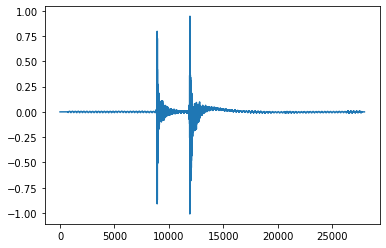

In [163]:
test_pd = category_id_pd.loc[category_id_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [164]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Hands (0.4722512662410736)
[Your model] The main sound is: double_claps (0.8715088963508606)
